In [1]:
# Import the dependencies.
# Mandatory
from sqlalchemy import create_engine, text, inspect

# ORM imports - for classes
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base

#data science
import pandas as pd
import matplotlib.pyplot as plt

# Other imports
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [4]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [5]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create a session
session = Session(engine)

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
print("Columns in measurement table")
for column in columns:
    print(column["name"], column["type"])

# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
print("\nColumns in station table")
for column in columns:
    print(column["name"], column["type"])

Columns in measurement table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Columns in station table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [7]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [8]:
# Find the most recent date in the data set. But this time using the SQL query
query = """ 
        SELECT date 
        FROM measurement 
        ORDER BY date DESC 
        LIMIT 1;
        """
# Save the query results as a Pandas DataFrame
recent_date_sql = pd.read_sql(text(query), con = engine)
recent_date_sql

,date
0,2017-08-23


<Axes: title={'center': 'Precipitation (12 months)'}, xlabel='Date', ylabel='Inches'>

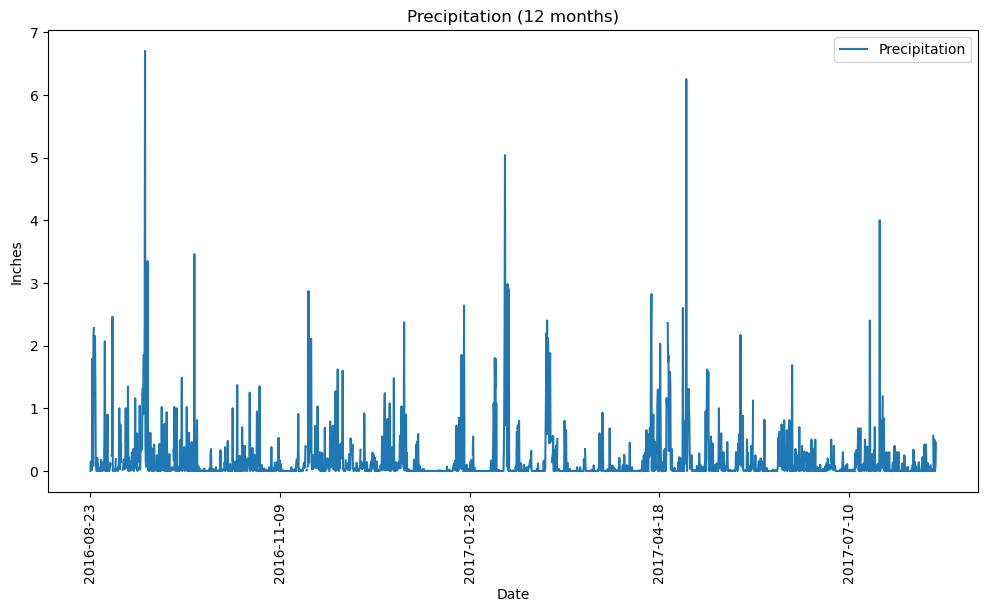

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_ago = most_recent_date - dt.timedelta(days=366) # When using the date from the database, we need to subtract 366 days to make sure it includes 2016-08-23

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation (12 months)", ylabel="Inches", figsize=[12,6], rot=90)

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. But this time using SQL query
# # Find the most recent date in the data set.
query = """ 
        SELECT date, prcp as Precipitation
        FROM measurement
        WHERE date >= (SELECT DATE(date, '-365 days') FROM measurement ORDER BY date DESC LIMIT 1)
        ORDER BY date;
        """
# Save the query results as a Pandas DataFrame
precipitation_sql_df = pd.read_sql(text(query), con = engine)
precipitation_sql_df.head()

,date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [12]:
precipitation_sql_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?). But this time using SQL query
# List the stations and their counts in descending order.
query = """ 
        SELECT station, COUNT(station) AS station_count
        FROM measurement
        GROUP BY station
        ORDER BY station_count DESC;
        """
# Save the query results as a Pandas DataFrame
active_stations_sql = pd.read_sql(text(query), con = engine)
active_stations_sql

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


##### Question: Which station id has the greatest number of observations?
##### Answer: Station USC00519281 has the most observations. 

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  # Since the query is ordered by count, the most active station is the first one

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. But this time using SQL query
query = """
        SELECT MIN(tobs) AS min_temp, MAX(tobs) AS max_temp, AVG(tobs) AS avg_temp
        FROM measurement
        WHERE station = (
                SELECT station 
                FROM (
                        SELECT station, COUNT(station) AS station_count 
                        FROM measurement 
                        GROUP BY station 
                        ORDER BY station_count DESC 
                        LIMIT 1
                        )
                );
        """
# Save the query results as a Pandas DataFrame
most_active_station_temp_sql = pd.read_sql(text(query), con = engine)
most_active_station_temp_sql

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


Text(0, 0.5, 'Frequency')

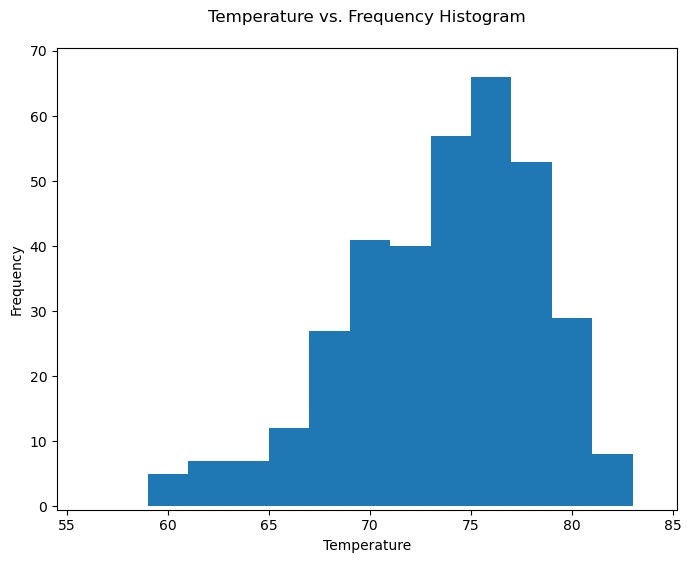

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == most_active_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['TOBS'])
temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram\n", legend=False, xlim=(54.5, 85.2), ylim=(-0.5, 70.5), figsize=[8,6])
plt.xlabel("Temperature")
plt.ylabel("Frequency")


# Close Session

In [19]:
# Close Session
session.close()
